In [42]:
# from pandas_datareader import data

import requests
import io

In [43]:
# Imports & Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import dateutil.parser
"""
parser.parse() automatically detects many date formats without you specifying the format string.
It returns a datetime.datetime object.
You can pass dayfirst=True if your dates are in DD/MM/YYYY format
"""

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load environment variables
from dotenv import load_dotenv
import os
from pathlib import Path

# Load .env file from current directory
env_path = Path('.env')
load_dotenv(env_path);

In [44]:
# import statsmodels.api as sm
import statsmodels.formula.api as smf

In [45]:
# Get path from environment variables
path_daily_returns_strategies = os.getenv('path_daily_returns_strategies')

# Full History for all the strategies
path = path_daily_returns_strategies
# print(f"Data file path: {path}")

# read csv file from path
df = pd.read_csv(path, sep=';') 

df.head()

,Date,Profit_pct_100
0,2023-04-17,0.05
1,2023-04-18,-0.00
2,2023-04-19,-0.01
3,2023-04-20,-0.00
4,2023-04-21,0.00


In [46]:
# Get path from environment variables
path_daily_returns_strategies = os.getenv('path_daily_returns_strategies')
path_daily_returns_spy = os.getenv('path_daily_returns_spy')

daily_returns_spy = pd.read_csv(path_daily_returns_spy, index_col=0, parse_dates=True, sep=';')
daily_returns_strategies = pd.read_csv(path_daily_returns_strategies, index_col=0, parse_dates=True, sep=';')

# Fix: Normalize dates to remove time component
daily_returns_spy.index = daily_returns_spy.index.normalize()
daily_returns_strategies.index = daily_returns_strategies.index.normalize()
# rename the columns
daily_returns_spy.columns = ['daily_returns_spy']
daily_returns_strategies.columns = ['daily_returns_strategies']

In [47]:
print(daily_returns_spy.head())
print(daily_returns_strategies.head())

            daily_returns_spy
datetime                     
2023-04-19                NaN
2023-04-20              -0.01
2023-04-21               0.00
2023-04-24               0.00
2023-04-25              -0.02
            daily_returns_strategies
Date                                
2023-04-17                      0.05
2023-04-18                     -0.00
2023-04-19                     -0.01
2023-04-20                     -0.00
2023-04-21                      0.00


In [48]:
# merge the two dataframes on the index (now with normalized dates)
merged_df = pd.merge(daily_returns_spy, daily_returns_strategies, left_index=True, right_index=True, how='inner')

# drop na values
merged_df = merged_df.dropna()

print(f"Merged DataFrame shape: {merged_df.shape}")
merged_df.head()

Merged DataFrame shape: (577, 2)


,daily_returns_spy,daily_returns_strategies
2023-04-20,-0.01,-0.00
2023-04-21,0.00,0.00
2023-04-24,0.00,-0.01
2023-04-26,-0.00,0.06
2023-04-28,0.01,0.00


In [49]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 577 entries, 2023-04-20 to 2025-10-31
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   daily_returns_spy         577 non-null    float64
 1   daily_returns_strategies  577 non-null    float64
dtypes: float64(2)
memory usage: 13.5 KB


In [50]:
# merged_df have daily returns for both SPY and strategies, indexed by date
# we need to compute the returns and grop them by month to match Fama-French data frequency
# last day of month for each date in the index

# add last day of month column
merged_df['DATE'] = merged_df.index.to_period('M').to_timestamp('M')

# group by month and compute daily returns to monthly returns
merged_df = merged_df.groupby('DATE').apply(lambda x: (1 + x).prod() - 1)

# drop na values
merged_df = merged_df.dropna()

# add two columns with compounded monthly returns
merged_df['cum_returns_spy'] = (1 + merged_df['daily_returns_spy']).cumprod() - 1
merged_df['cum_returns_strategies'] = (1 + merged_df['daily_returns_strategies']).cumprod() - 1

merged_df.head()

,daily_returns_spy,daily_returns_strategies,cum_returns_spy,cum_returns_strategies
DATE,,,,
2023-04-30,0.00,0.05,0.00,0.05
2023-05-31,0.00,0.13,0.00,0.19
2023-06-30,0.08,0.03,0.09,0.22
2023-07-31,0.03,-0.06,0.12,0.15
2023-08-31,-0.01,-0.00,0.11,0.15


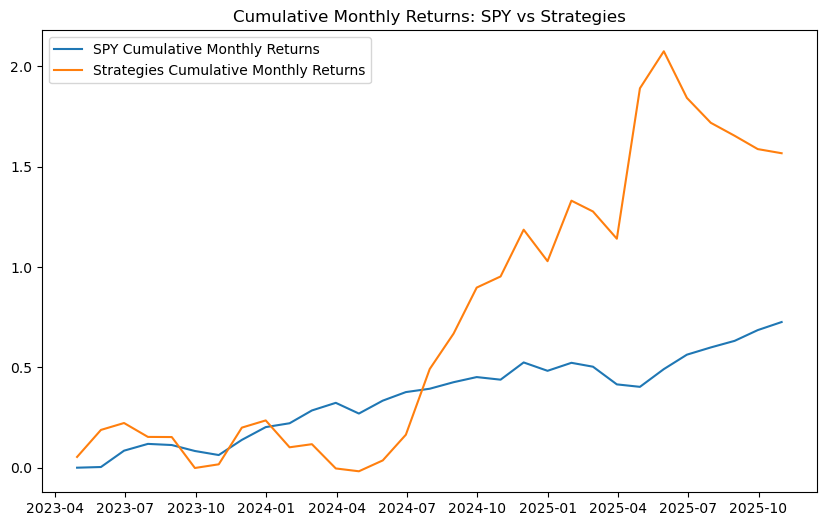

In [51]:
# plot merged_df.cum_returns_spy  
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df['cum_returns_spy'], label='SPY Cumulative Monthly Returns')
plt.plot(merged_df.index, merged_df['cum_returns_strategies'], label='Strategies Cumulative Monthly Returns')
plt.title('Cumulative Monthly Returns: SPY vs Strategies') 
plt.legend()
plt.show()

In [ ]:
url_qmj = "https://www.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Quality-Minus-Junk-Factors-Monthly.xlsx"
url_bab = "https://www.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Betting-Against-Beta-Equity-Factors-Monthly.xlsx"

In [ ]:
response = requests.get(url_qmj)
f = io.BytesIO(response.content)

In [ ]:
# Quality-Minus-Junk Factors Monthly
df_qmj=pd.read_excel(io=f, sheet_name='QMJ Factors', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'QMJ'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_qmj_ = df_qmj.copy()
df_qmj.head()

,DATE,QMJ
0,1957-07-31,0.01
1,1957-08-31,0.00
2,1957-09-30,0.01
3,1957-10-31,0.00
4,1957-11-30,-0.01


In [ ]:
response = requests.get(url_bab)
f = io.BytesIO(response.content)

In [ ]:
# Betting-Against-Beta Equity Factors Monthly
df_bab = pd.read_excel(io=f, sheet_name='BAB Factors', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'BAB'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_bab_ = df_bab.copy()
df_bab_.head()

,DATE,BAB
0,1930-12-31,-0.00
1,1931-01-31,-0.02
2,1931-02-28,-0.08
3,1931-03-31,0.03
4,1931-04-30,-0.01


In [ ]:
# HML High Minus Low Equity Factors Monthly
df_hml = pd.read_excel(io=f, sheet_name='HML FF', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'HML'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_hml_ = df_hml.copy()
df_hml_.head()

,DATE,HML
0,1926-07-31,-0.03
1,1926-08-31,0.05
2,1926-09-30,-0.01
3,1926-10-31,0.01
4,1926-11-30,0.00


In [ ]:
# SMB Small Minus Big Equity Factors Monthly
df_smb = pd.read_excel(io=f, sheet_name='SMB', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'SMB'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_smb_ = df_smb.copy()
df_smb_.head()

,DATE,SMB
0,1926-07-31,-0.02
1,1926-08-31,-0.01
2,1926-09-30,-0.01
3,1926-10-31,0.01
4,1926-11-30,-0.01


In [ ]:
# UMD Up Minus Down Equity Factors Monthly
df_umd = pd.read_excel(io=f, sheet_name='UMD', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'UMD'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_umd_ = df_umd.copy()
df_umd_.head()

,DATE,UMD
0,1927-01-31,0.03
1,1927-02-28,-0.01
2,1927-03-31,0.05
3,1927-04-30,0.03
4,1927-05-31,0.05


In [ ]:
# Risk Free Rate Monthly
df_rfr = pd.read_excel(io=f, sheet_name='RF', skiprows=18, usecols="A:B")[['DATE', 'Risk Free Rate']].rename(columns={'Risk Free Rate': 'RF'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_rfr_ = df_rfr.copy()
df_rfr_.head()

,DATE,RF
0,1926-07-31,0.00
1,1926-08-31,0.00
2,1926-09-30,0.00
3,1926-10-31,0.00
4,1926-11-30,0.00


In [ ]:
# Market Equity Factors Monthly
df_mkt = pd.read_excel(io=f, sheet_name='MKT', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'MKT'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_mkt_ = df_mkt.copy()
df_mkt_.head()

,DATE,MKT
0,1926-07-31,0.03
1,1926-08-31,0.03
2,1926-09-30,0.00
3,1926-10-31,-0.03
4,1926-11-30,0.02


In [ ]:
# merging all dfs
model_data = (
    merged_df
    .reset_index()
    .rename(columns={'index': 'DATE'})
    .merge(df_rfr, how='inner', on='DATE')
    .merge(df_mkt, how='inner', on='DATE')
    .merge(df_hml, how='inner', on='DATE')
    .merge(df_smb, how='inner', on='DATE')
    .merge(df_umd, how='inner', on='DATE')
    .merge(df_qmj, how='inner', on='DATE')
    .merge(df_bab, how='inner', on='DATE')
)

model_data.head()

,DATE,daily_returns_spy,daily_returns_strategies,RF,MKT,HML,SMB,UMD,QMJ,BAB
0,2023-06-30,0.01,-0.00,0.00,0.07,-0.01,0.01,-0.03,-0.01,-0.01
1,2023-08-31,-0.00,0.02,0.00,-0.03,-0.01,-0.02,0.04,0.04,0.02
2,2023-10-31,0.01,0.00,0.00,-0.03,-0.00,-0.04,0.03,0.04,0.04
3,2023-11-30,0.00,-0.01,0.00,0.09,0.00,0.00,0.02,-0.03,-0.01
4,2024-01-31,-0.02,-0.05,0.00,0.00,-0.01,-0.04,0.05,-0.00,0.01


In [ ]:
# Merge buffett_ with df_rfr_ on month_end = DATE
# Remove timezone from month_end to match DATE column
model_data_ = buffett_.copy()
model_data_['month_end'] = model_data_['month_end'].dt.tz_localize(None)
model_data_ = model_data_.merge(df_rfr_, left_on='month_end', right_on='DATE', how='left')

# Drop redundant DATE column
model_data_ = model_data_.drop(columns=['DATE'])

# Add BRK column as Return - RF
model_data_['BRK'] = model_data_['Return'] - model_data_['RF']

model_data_.head()

In [ ]:
# merge model_data_ with the other factor dataframes on month_end = DATE
model_data_ = model_data_.merge(df_mkt_, left_on='month_end', right_on='DATE', how='left').drop(columns=['DATE'])
model_data_ = model_data_.merge(df_hml_, left_on='month_end', right_on='DATE', how='left').drop(columns=['DATE'])
model_data_ = model_data_.merge(df_smb_, left_on='month_end', right_on='DATE', how='left').drop(columns=['DATE'])
model_data_ = model_data_.merge(df_umd_, left_on='month_end', right_on='DATE', how='left').drop(columns=['DATE'])
model_data_ = model_data_.merge(df_qmj_, left_on='month_end', right_on='DATE', how='left').drop(columns=['DATE'])
model_data_ = model_data_.merge(df_bab_, left_on='month_end', right_on='DATE', how='left').drop(columns=['DATE'])

# ffill na 
model_data_ = model_data_.fillna(method='ffill')

# drop rows with na
model_data_ = model_data_.dropna()

model_data_.head()

In [ ]:
ax = (
    model_data
    .drop(['Close', 'RF', 'BRK'], axis=1)
    .set_index('DATE')
    .apply(lambda x: (1 + x).cumprod())
    .plot()
)
ax.set_facecolor('#E2E5E8')
fig = ax.get_figure()
fig.set_facecolor('#E2E5E8') 
plt.grid()
plt.yscale("log")
plt.title('Long-term performance of Equity Risk Factors')
# fig.savefig('risk_factor_performance', bbox_inches='tight')

plt.show()


In [ ]:
# drop 'Close', 'RF', 'BRK' from model_data_    
model_data_ = model_data_.drop(columns=['Close', 'RF', 'BRK'])

# set month_end as index
model_data_ = model_data_.set_index('month_end')

# calculate cumulative product of (1 + each column)
model_data_ = model_data_.apply(lambda x: (1 + x).cumprod())

model_data_.head()

In [ ]:
# plot regression of BRK vs MKT, HML, SMB, UMD, QMJ, BAB
import statsmodels.api as sm

X = model_data_[['MKT', 'HML', 'SMB', 'UMD', 'QMJ', 'BAB']]
y = model_data_['Return']
X = sm.add_constant(X)  # add constant term for intercept

model = sm.OLS(y, X).fit()
print(model.summary())

# plot actual vs predicted BRK returns
plt.figure(figsize=(16,10))
plt.scatter(model_data_.index, y, label='Actual BRK Returns')
plt.plot(model_data_.index, model.predict(X), color='red', label='Predicted BRK Returns')
plt.title('Actual vs Predicted BRK Returns')
plt.xlabel('Date')
plt.ylabel('BRK Returns')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# The alpha is:
alpha_monthly = res.params['Intercept']
alpha_annualized = alpha_monthly * 12  # Annualize it

print(f"Monthly Alpha: {alpha_monthly:.4f} ({alpha_monthly*100:.2f}%)")
print(f"Annualized Alpha: {alpha_annualized:.4f} ({alpha_annualized*100:.2f}%)")

In [ ]:
mod = smf.ols('BRK ~ MKT', model_data)
res = mod.fit()
print(res.summary())

In [ ]:
mod = smf.ols('BRK ~ MKT + HML + SMB + UMD', model_data)
res = mod.fit()
print(res.summary())

In [ ]:
mod = smf.ols('BRK ~ MKT + HML + SMB + UMD + QMJ + BAB', model_data)
res = mod.fit()
print(res.summary())